### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import sys  
sys.path.insert(0, '../')

import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math
from matplotlib import cm
import matplotlib 

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 0

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-05-31 11:30:44.974666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 11:30:46.011086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Model creation function

In [2]:
def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()

    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation='relu'))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Hyperparameter space

In [3]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 40],
    #'batch_size': ["interval-int", 1, 200],
    'learning rate': ["interval-log", 1e-10, 1e-1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

### Optimization

Adaptive grid generation (Ritter-Novak)...


2023-05-31 11:30:48.597416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Done in 23436ms.


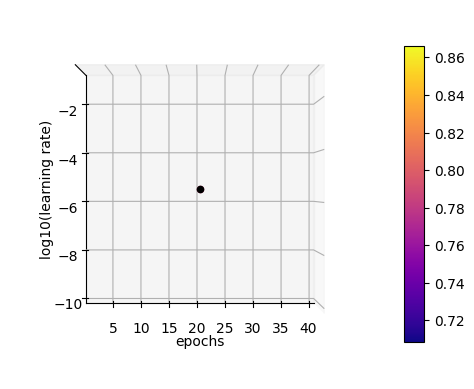

Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.


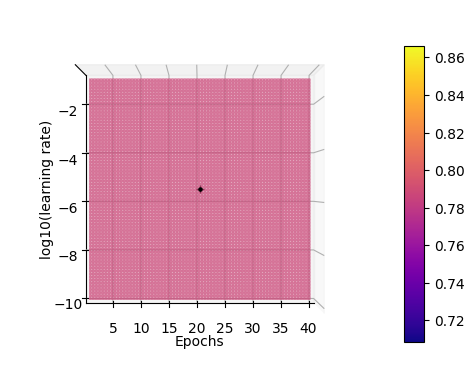

Adaptive grid generation (Ritter-Novak)...
Done in 123376ms.


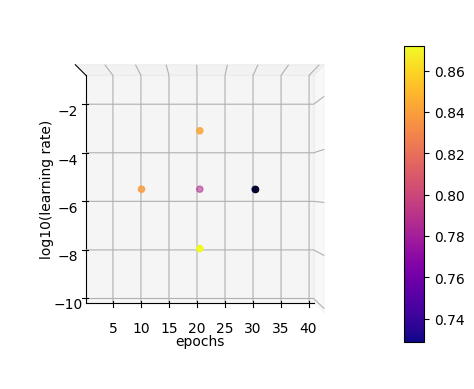

Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.


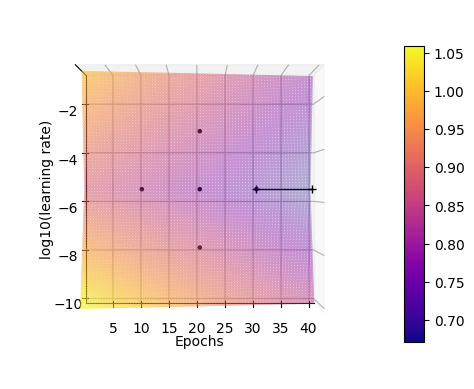

Adaptive grid generation (Ritter-Novak)...
Done in 307018ms.


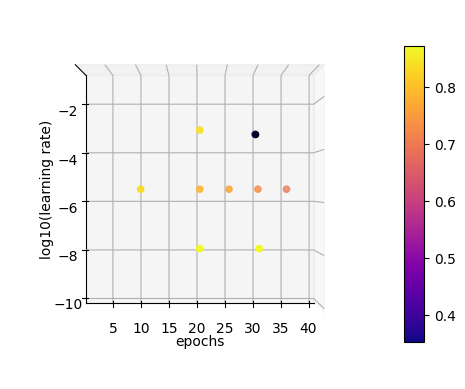

Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.


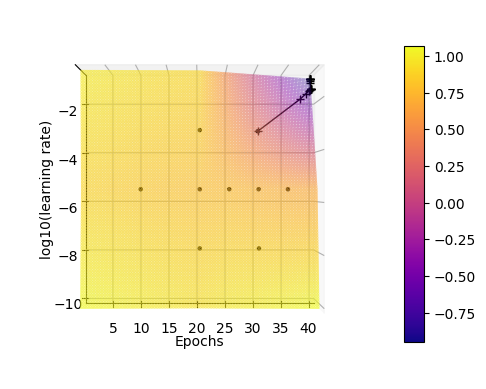

Adaptive grid generation (Ritter-Novak)...
Done in 508658ms.


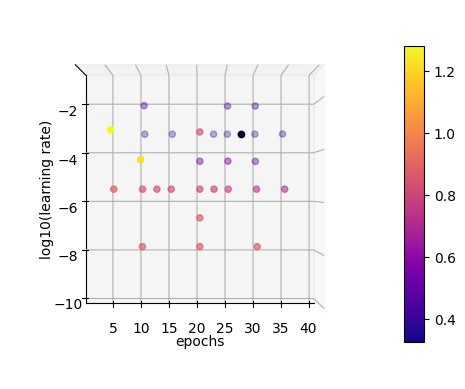

Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.


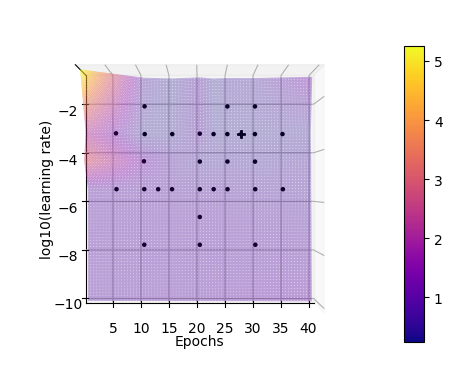

In [4]:

################## MODEL AND FUNCTION DEFINITION ####################
CV = 2
dataset = HPO.Dataset(task_id=233211)

def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):
    # sum = 0
    # sum += epochs ** 2 - 10 * math.cos(2 * math.pi * epochs)
    # sum += learning_rate ** 2 - 10 * math.cos(2 * math.pi * learning_rate)
    # # sum += learning_rate ** 2 - 10 * math.cos(2 * math.pi * learning_rate)
    # # sum += number_of_layers ** 2 - 10 * math.cos(2 * math.pi * number_of_layers)
    # # sum += neurons_per_layer ** 2 - 10 * math.cos(2 * math.pi * neurons_per_layer)
    # return len(hyperparameterspace) * 10 + sum

    # sum = 0
    # sum += (1-epochs)**2 + 100 * (learning_rate - epochs**2) ** 2
    # return sum
    #return epochs

    kfold = KFold(n_splits=CV)

    split = (kfold.split(dataset.get_X(), dataset.get_Y()))

    values = []

    numeric_features = [not x for x in dataset.get_categorical_indicator()]
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(
                handle_unknown="infrequent_if_exist", sparse_output=False)),
            # ("selector", SelectPercentile(chi2, percentile=50)),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer,
                dataset.get_categorical_indicator()),
        ]
    )

    for i, (train_index, test_index) in enumerate(split):

        if deterministic:
            reset_seeds()

        X_train = dataset.get_X()[train_index]
        Y_train = dataset.get_Y()[train_index]

        X_val = dataset.get_X()[test_index]
        Y_val = dataset.get_Y()[test_index]

        preprocessor.fit(X_train, Y_train)

        X_train = preprocessor.transform(X_train)
        X_val = preprocessor.transform(X_val)

        regressor = KerasRegressor(model=create_model,
                                    learning_rate=learning_rate,
                                    input_dim=len(
                                        X_train[0]),
                                    number_layers=number_of_layers,
                                    neurons_per_layer=neurons_per_layer,
                                    verbose=0)

        regressor = TransformedTargetRegressor(regressor=regressor,
                                                transformer=StandardScaler())

        regressor.fit(X_train, Y_train, epochs=int(epochs),
                        batch_size=int(batch_size), shuffle=False)

        Y_predicted = regressor.predict(X_val)
        # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
        error = sklearn.metrics.mean_absolute_percentage_error(
            Y_predicted, Y_val)
        values.append(error)

        del regressor
        K.clear_session()

    result = sum(values)/len(values)
    return result



class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(
            len(hyperparameterspace.keys()))

    def eval(self, x):
        epochs = int(HPO.from_standard(
            hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

        batch_size = 100 

        model_learning_rate = HPO.from_standard_log(
            hyperparameterspace_special["learning rate"][0], hyperparameterspace_special["learning rate"][1], x[1])

        number_of_layers = 1

        neurons_per_layer = 30

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

BUDGETS = [1, 5, 10, 30]


for budget in BUDGETS:

    optimizer = HPO.SparseGridSearchOptimization(dataset, ExampleFunction(), hyperparameterspace, budget, verbosity=1, degree=2, adaptivity=0.85)
    optimizer = optimizer.fit()

    x = []
    y = []
    history_points = optimizer.getHistoryOfOptimalPoints()
    for i in range(history_points.getNrows()):
        vec = pysgpp.DataVector(history_points.getNcols())
        history_points.getRow(i, vec)
        x.append(vec[0])
        y.append(vec[1])

    # fig, ax = plt.subplots()
    # img = plt.imread("function.png")
    # ax.imshow(img, extent=[0, 1, 0, 1])
    # plt.plot(x, y, color="white")

    # # naming the x axis
    # plt.xlabel('x')
    # # naming the y axis
    # plt.ylabel('y')

    # plt.xlim([0,1])
    # plt.ylim([0,1])

    # function to show the plot
    plt.show()
